In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Funtions used:

In [2]:
def interactive_stock_selector(start, end):
    # Clean and fix ticker formats
    tickers_df = pd.read_csv("Companies and Types.csv")
    tickers_df['Company'] = tickers_df['Company'].astype(str).str.strip().str.upper()
    tickers_df['Company'] = tickers_df['Company'].apply(lambda x: x if x.endswith('.NS') else x + '.NS')
    tickers_df = tickers_df[~tickers_df['Company'].str.contains('COMPANY|TYPE|NAN|NULL|NONE', case=False)]

    # Normalize 'Type' column
    tickers_df = tickers_df.copy()
    tickers_df['Type'] = tickers_df['Type'].astype(str).str.strip().str.upper()

    # Step 0: Ask cap type preference
    print("\n🏢 Choose market cap types for your portfolio:")
    print("1. Large Cap")
    print("2. Mid Cap")
    print("3. Small Cap")
    print("4. Large + Mid")
    print("5. Mid + Small")
    print("6. Large + Small")
    print("7. All (Large + Mid + Small)")
    cap_choice = input("Enter choice (1-7): ")

    cap_map = {
        '1': ['LARGECAP'],
        '2': ['MIDCAP'],
        '3': ['SMALLCAP'],
        '4': ['LARGECAP', 'MIDCAP'],
        '5': ['MIDCAP', 'SMALLCAP'],
        '6': ['LARGECAP', 'SMALLCAP'],
        '7': ['LARGECAP', 'MIDCAP', 'SMALLCAP']
    }
    selected_caps = cap_map.get(cap_choice, ['LARGE CAP', 'MID CAP', 'SMALL CAP'])
    tickers_df = tickers_df[tickers_df['Type'].isin(selected_caps)]
    tickers = tickers_df['Company'].tolist()

    if not tickers:
        print("❌ No tickers match the selected cap types.")
        return []

    print(f"\n📋 Total tickers selected after cap filter: {len(tickers)}")
    print(tickers[:10], "...\n")  # Print a few tickers to verify

    # Step 1: User preferences
    print("\n💡 Choose your investor profile:")
    print("1. Beginner (balanced)")
    print("2. Aggressive (return-focused)")
    print("3. Conservative (risk-averse)")
    profile = input("Enter 1, 2 or 3: ")

    if profile == '1':
        min_vol = 800_000
        max_volatility = 0.35
    elif profile == '2':
        min_vol = 500_000
        max_volatility = 0.5
    elif profile == '3':
        min_vol = 1_200_000
        max_volatility = 0.25
    else:
        print("Invalid choice. Defaulting to balanced.")
        min_vol = 1_000_000
        max_volatility = 0.4

    print("\n🎯 Select stock ranking strategy:")
    print("1. High Sharpe Ratio")
    print("2. High Momentum (Return)")
    print("3. Low Volatility")
    strategy_input = input("Enter 1, 2 or 3: ")
    sort_by = {'1': 'Sharpe', '2': 'Return', '3': 'Volatility'}.get(strategy_input, 'Sharpe')

    total_stocks = int(input("\n📦 How many total stocks in your portfolio? (e.g., 15, 20, 30): "))

    # Step 2: Batching logic
    end = end
    start = start
    batch_size = 100
    results = []

    print("\n⏳ Processing tickers in batches...\n")

    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"🔄 Downloading batch {i // batch_size + 1} of {len(tickers) // batch_size + 1}")
        for attempt in range(3):
            try:
                data = yf.download(batch, start=start, end=end, group_by='ticker', progress=False, auto_adjust=False)
                if not data.empty:
                    break
            except Exception as e:
                print(f"Attempt {attempt + 1} failed for batch: {e}")
                time.sleep(2)
        else:
            print(f"⚠️ Batch failed after retries.")
            continue

        for ticker in batch:
            try:
                if isinstance(data.columns, pd.MultiIndex):
                    if ticker not in data.columns.get_level_values(0):
                        print(f"⚠️ {ticker} not in downloaded data.")
                        continue
                    df = data[ticker]
                else:
                    df = data.copy()

                if df.empty or 'Adj Close' not in df or 'Volume' not in df:
                    print(f"⚠️ No Adj Close or Volume for {ticker}. Skipping.")
                    continue

                returns = np.log(df['Adj Close']/df['Adj Close'].shift(1)).dropna()
                mean_ret = float(returns.mean() * 252)
                std_dev = float(returns.std() * np.sqrt(252))
                sharpe = (mean_ret - 0.05) / std_dev if std_dev != 0 else 0
                avg_volume = float(df['Volume'].mean())

                results.append({
                    'Ticker': ticker,
                    'Sharpe': sharpe,
                    'Return': mean_ret,
                    'Volatility': std_dev,
                    'AvgVolume': avg_volume
                })

            except Exception as e:
                print(f"⚠️ Skipping {ticker}: {e}")
                continue

    df_result = pd.DataFrame(results)
    if df_result.empty:
        print("❌ No valid stock data was processed. Make sure tickers are correct and yfinance is not rate-limiting.")
        return []

    if 'AvgVolume' not in df_result.columns or 'Volatility' not in df_result.columns:
        print("⚠️ Data missing for volume or volatility. Returning fallback list by Sharpe.")
        fallback_results = sorted(results, key=lambda x: x['Sharpe'], reverse=True)
        fallback_tickers = [x['Ticker'] for x in fallback_results[:total_stocks]]
        return fallback_tickers

    df_result = df_result[(df_result['AvgVolume'] >= min_vol) & (df_result['Volatility'] <= max_volatility)]

    if df_result.empty:
        print("⚠️ No stocks matched your filters. Returning top stocks by Sharpe instead.")
        fallback_results = sorted(results, key=lambda x: x['Sharpe'], reverse=True)
        fallback_tickers = [x['Ticker'] for x in fallback_results[:total_stocks]]
        return fallback_tickers

    ascending = True if sort_by == 'Volatility' else False
    df_result = df_result.sort_values(by=sort_by, ascending=ascending)

    df_result.head(total_stocks).to_csv("selected_portfolio.csv", index=False)
    print("✅ Portfolio exported to 'selected_portfolio.csv'")
    return df_result['Ticker'].head(total_stocks).tolist()

In [39]:
def get_data(stocks, benchmark, start, end):
    # Step 1: Download stock data
    data = yf.download(stocks, start=start, end=end, auto_adjust=False)

    # Step 2: Format benchmark data
    if benchmark.shape[1] == 6:
        benchmark.columns = ['Index Name', 'Date', 'Open', 'High', 'Low', 'Close']
    elif benchmark.shape[1] == 5:
        benchmark.columns = ['Date', 'Open', 'High', 'Low', 'Close']
    else:
        raise ValueError("Unexpected number of columns in benchmark file")

    # Step 3: Clean Date column
    if benchmark['Date'].astype(str).str.contains('-').any():
        benchmark['Date'] = benchmark['Date'].str.replace('-', ' ', regex=False)
    
    benchmark['Date'] = pd.to_datetime(benchmark['Date'], format='%d %b %y', errors='coerce')
    benchmark.dropna(subset=['Date'], inplace=True)
    benchmark = benchmark.sort_values('Date').set_index('Date')

    # Step 4: Extract Close column as Benchmark
    benchmark = benchmark[['Close']].rename(columns={'Close': 'Benchmark'})

    # Step 5: Align benchmark with start and end
    start = pd.to_datetime(start).normalize()
    end = pd.to_datetime(end).normalize()
    benchmark = benchmark.truncate(before=start, after=end).copy()

    # Step 6: Stock returns
    adj_close = data['Adj Close']
    daily_pctret = adj_close.pct_change(fill_method=None).dropna()
    benchmark_pctret = benchmark.pct_change(fill_method=None).dropna()
    daily_logret = np.log(adj_close / adj_close.shift(1)).dropna()
    benchmark_logret = np.log(benchmark / benchmark.shift(1)).dropna()

    # Step 7: Expected return and covariance
    exp_ret = daily_logret.mean(axis=0) * 252
    cov_matrix = daily_logret.cov() * 252

    return daily_logret, daily_pctret, exp_ret, cov_matrix, benchmark_pctret, benchmark_logret

In [4]:
def portfolio_creation(stocks, exp_ret, cov_matrix):
    rf = 0.0627
    simulations = 10000
    portfolio_returns = []
    portfolio_volatility = []
    portfolio_weights = []
    portfolio_sharpe = []
    portfolio_sortino = []
    for _ in range(simulations):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)

        # Annualized return and volatility
        port_return = float(np.sum(exp_ret * weights))
        port_vol = float(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
        sharpe_ratio = (port_return - rf) / port_vol

        # Daily portfolio returns (for downside deviation)
        port_daily_returns = exp_ret.dot(weights)

        # Calculate downside deviation (only days when return < rf/252)
        downside_returns = port_daily_returns[port_daily_returns < (rf / 252)]
        downside_deviation = np.std(downside_returns) if len(downside_returns) > 0 else 0.0001  # avoid zero-div
        sortino_ratio = ((port_return - rf) / (downside_deviation * np.sqrt(252)))

        # Store results
        portfolio_weights.append(weights * 100)
        portfolio_returns.append(port_return * 100)
        portfolio_volatility.append(port_vol * 100)
        portfolio_sharpe.append(sharpe_ratio)
        portfolio_sortino.append(sortino_ratio)
    
    portfolio_simulations = {
        "returns": portfolio_returns,
        "volatility": portfolio_volatility,
        "sharpe_ratios": portfolio_sharpe,
        "sortino_ratios": portfolio_sortino,
        "weights": portfolio_weights
    }
    
    return portfolio_simulations

In [5]:
def optimal_portfolio(portfolio_simulations):
    portfolio_simulations['returns'] = np.array(portfolio_simulations['returns'])
    portfolio_simulations['volatility'] = np.array(portfolio_simulations['volatility'])
    portfolio_simulations['sharpe_ratios'] = np.array(portfolio_simulations['sharpe_ratios'])
    portfolio_simulations['sortino_ratios'] = np.array(portfolio_simulations['sortino_ratios'])
    weights_list = np.array(portfolio_simulations['weights'])
    
    max_sharpe_idx = np.argmax(portfolio_simulations['sharpe_ratios'])
    min_volatility_idx = np.argmin(portfolio_simulations['volatility'])
    max_sortino_idx = np.argmax(portfolio_simulations['sortino_ratios'])
    
    # Tangent Portfolio (Max Sharpe)
    tangent_portfolio = {
        "returns": portfolio_simulations['returns'][max_sharpe_idx],
        "volatility": portfolio_simulations['volatility'][max_sharpe_idx],
        "sharpe_ratio": portfolio_simulations['sharpe_ratios'][max_sharpe_idx],
        "sortino_ratio": portfolio_simulations['sortino_ratios'][max_sharpe_idx],
        "weights": portfolio_simulations['weights'][max_sharpe_idx]
    }

    # Minimum Variance Portfolio
    min_variance_portfolio = {
        "returns": portfolio_simulations['returns'][min_volatility_idx],
        "volatility": portfolio_simulations['volatility'][min_volatility_idx],
        "sharpe_ratio": portfolio_simulations['sharpe_ratios'][min_volatility_idx],
        "sortino_ratio": portfolio_simulations['sortino_ratios'][min_volatility_idx],
        "weights": portfolio_simulations['weights'][min_volatility_idx]
    }

    # Maximum Sortino Portfolio
    max_sortino_portfolio = {
        "returns": portfolio_simulations['returns'][max_sortino_idx],
        "volatility": portfolio_simulations['volatility'][max_sortino_idx],
        "sharpe_ratio": portfolio_simulations['sharpe_ratios'][max_sortino_idx],
        "sortino_ratio": portfolio_simulations['sortino_ratios'][max_sortino_idx],
        "weights": portfolio_simulations['weights'][max_sortino_idx]
    }

    return tangent_portfolio, min_variance_portfolio, max_sortino_portfolio

In [6]:
def visualize_portfolio(portfolio_simulations,tangent_portfolio,min_variance_portfolio,max_sortino_portfolio):
    plt.figure(figsize = (12,9))
    plt.style.use("dark_background")
    plt.scatter(portfolio_simulations["volatility"], portfolio_simulations["returns"], c = portfolio_simulations["sharpe_ratios"], cmap = "coolwarm", marker = 'o', s = 10, alpha = 0.3)
    plt.colorbar(label = "Sharpe Ratio")
    plt.xlabel("Portfolio Volatility(in %)")
    plt.ylabel("Portfolio Returns(in %)")
    plt.title('Portfolio Optimization with Efficient Frontier')
    
    plt.scatter(tangent_portfolio['volatility'], tangent_portfolio['returns'], marker='*', color='g', s=200, label='Maximum Sharpe Ratio')
    plt.scatter(min_variance_portfolio['volatility'], min_variance_portfolio['returns'], marker='*', color='b', s=200, label='Minimum Volatility(in %)')
    plt.scatter(max_sortino_portfolio['volatility'], max_sortino_portfolio['returns'], marker='*', color='y', s=200, label='Maximum Sortino Ratio')
    plt.legend()

In [7]:
def value_at_risk(daily_logret, portfolio):
    var_cvar = {}
    simulations = 5000
    confidence_interval = 0.95
    weights = np.array(portfolio["weights"]) / 100
    returns = daily_logret @ weights

    # Historical
    var_cvar["Historical VaR"] = np.percentile(returns, 100 - (confidence_interval * 100))
    var_cvar["Historical CVaR"] = returns[returns <= var_cvar["Historical VaR"]].mean()

    # Parametric
    z_score = norm.ppf(1 - confidence_interval)
    portfolio_mean = returns.mean()
    portfolio_volatility = returns.std()
    var_cvar["Parametric VaR"] = (portfolio_mean + z_score * portfolio_volatility)

    # Monte Carlo
    simulated_returns = np.random.normal(portfolio_mean, portfolio_volatility, simulations)
    var_cvar["Monte Carlo VaR"] = np.percentile(simulated_returns, 100 - (confidence_interval * 100))
    var_cvar["Monte Carlo CVaR"] = simulated_returns[simulated_returns <= var_cvar["Monte Carlo VaR"]].mean()

    # Print results
    print("\n🔎 Value at Risk (VaR) and Conditional VaR (CVaR):")
    for k, v in var_cvar.items():
        print(f"{k}: {v:.4f}")

    # Plot histogram
    plt.figure(figsize=(14, 6))
    sns.histplot(returns, kde=True, bins=50, stat='density', color='skyblue')
    x = np.linspace(returns.min(), returns.max(), 100)
    plt.plot(x, norm.pdf(x, returns.mean(), returns.std()), 'r--', label='Normal Dist')
    
    plt.axvline(var_cvar["Historical VaR"], color='r', linestyle="--", label="Historical VaR")
    plt.axvline(var_cvar["Historical CVaR"], color='g', linestyle="--", label="Historical CVaR")
    plt.axvline(var_cvar["Parametric VaR"], color='y', linestyle="--", label="Parametric VaR")
    plt.axvline(var_cvar["Monte Carlo VaR"], color='orange', linestyle="--", label="Monte Carlo VaR")
    plt.axvline(var_cvar["Monte Carlo CVaR"], color='purple', linestyle="--", label="Monte Carlo CVaR")

    plt.title(f"Portfolio Risk Metrics (VaR @ {int(confidence_interval*100)}% Confidence)")
    plt.xlabel("Daily Log Returns")
    plt.ylabel("Density")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [57]:
def alpha_beta(daily_logret, benchmark_logret, portfolio, start, end, daily_rf=0.0586/252):
    # Normalize date index
    daily_logret.index = pd.to_datetime(daily_logret.index).normalize()
    benchmark_logret.index = pd.to_datetime(benchmark_logret.index).normalize()

    # Create portfolio returns
    weights = np.array(portfolio['weights'])
    port_ret = (daily_logret @ weights).rename("Portfolio")

    # Join data on common dates
    df = pd.concat([port_ret, benchmark_logret.squeeze()], axis=1, join='inner')
    df.columns = ['Portfolio', 'Benchmark']

    # Check for overlap
    if df.empty:
        print("❌ No overlapping dates. Check input ranges.")
        print("Portfolio dates:", port_ret.index.min(), "to", port_ret.index.max())
        print("Benchmark dates:", benchmark_logret.index.min(), "to", benchmark_logret.index.max())
        return None

    # Calculate excess returns
    excess_portfolio = df['Portfolio'] - daily_rf
    excess_market = df['Benchmark'] - daily_rf

    # CAPM regression
    x = sm.add_constant(excess_market)
    y = excess_portfolio
    capm_model = sm.OLS(y, x).fit()
    alpha, beta = capm_model.params

    # Treynor ratio
    treynor_ratio = ((portfolio["returns"] / 100) - daily_rf * 252) / beta

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.regplot(x=excess_market, y=excess_portfolio, line_kws={"color": "red"}, scatter_kws={"alpha": 0.5})
    plt.title("CAPM Regression: Excess Portfolio vs Excess Market Returns")
    plt.xlabel("Excess Market Return")
    plt.ylabel("Excess Portfolio Return")
    plt.grid(True)
    
    # Annotation
    plt.annotate(
    f'Alpha: {alpha*252:.4f}\nBeta: {beta/100:.4f}\nR²: {capm_model.rsquared:.4f}',
    xy=(0.05, 0.95), xycoords='axes fraction',
    fontsize=10,
    color='white',  # <-- fixes the invisible text on dark background
    backgroundcolor='black',  # Optional: matches the dark theme
    verticalalignment='top'
    )
    
    plt.tight_layout()
    plt.show()

    return {
        'alpha (annualized)': round(alpha * 252, 5),
        'beta': round(beta/100, 5),
        'treynor_ratio': round(treynor_ratio, 5),
        'r_squared': round(capm_model.rsquared, 4),
    }

In [53]:
def backtesting(pct_ret, benchmark_pctret, portfolio_weights, start, end):
    drawdown_dict = {}
    daily_rf = 0.0627 / 252
    portfolio_returns = pct_ret @ (portfolio_weights / 100)

    combined = pd.concat([portfolio_returns, benchmark_pctret], axis=1, join='inner')
    combined.columns = ["Portfolio", "Benchmark"]

    # Cumulative Returns
    plt.figure(figsize=(10, 6))
    portfolio_cumret = (1 + combined["Portfolio"]).cumprod() - 1
    benchmark_cumret = (1 + combined["Benchmark"]).cumprod() - 1

    plt.plot(portfolio_cumret, label='Portfolio')
    plt.plot(benchmark_cumret, label='Benchmark')
    plt.title("Cumulative returns: Portfolio vs Benchmark")
    plt.xlabel("Year")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Rolling Volatility
    plt.figure(figsize=(10, 6))
    volatility_window = 21
    portfolio_rollingvol = combined["Portfolio"].rolling(volatility_window).std() * np.sqrt(252)
    benchmark_rollingvol = combined["Benchmark"].rolling(volatility_window).std() * np.sqrt(252)

    plt.plot(portfolio_rollingvol, label='Portfolio')
    plt.plot(benchmark_rollingvol, label='Benchmark')
    plt.title("Rolling Volatility: Portfolio vs Benchmark")
    plt.xlabel("Year")
    plt.ylabel("Rolling Volatility (21 days)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Rolling Sharpe Ratio
    plt.figure(figsize=(10, 6))
    sharpe_window = min(50, len(portfolio_returns) // 2)
    rolling_portfolio_sharpe = (combined["Portfolio"].rolling(sharpe_window).mean() - daily_rf) / combined["Portfolio"].rolling(sharpe_window).std()
    rolling_benchmark_sharpe = (combined["Benchmark"].rolling(sharpe_window).mean() - daily_rf) / combined["Benchmark"].rolling(sharpe_window).std()

    plt.plot(rolling_portfolio_sharpe, label='Portfolio')
    plt.plot(rolling_benchmark_sharpe, label='Benchmark')
    plt.title("Rolling Sharpe Ratio: Portfolio vs Benchmark")
    plt.xlabel("Year")
    plt.ylabel("Sharpe Ratio (Rolling 50 days)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Drawdown
    plt.figure(figsize=(10, 6))

    # Calculate cumulative returns
    drawdown_portfolio_cumret = (1 + combined["Portfolio"]).cumprod()
    drawdown_benchmark_cumret = (1 + combined["Benchmark"]).cumprod()
    
    # Calculate drawdowns
    portfolio_peak = drawdown_portfolio_cumret.cummax()
    portfolio_drawdown = (drawdown_portfolio_cumret - portfolio_peak) / portfolio_peak
    
    benchmark_peak = drawdown_benchmark_cumret.cummax()
    benchmark_drawdown = (drawdown_benchmark_cumret - benchmark_peak) / benchmark_peak
    
    # Print max drawdown
    print("📉 Maximum Drawdown of the Portfolio:", portfolio_drawdown.min())
    print("📉 Maximum Drawdown of the Benchmark:", benchmark_drawdown.min())
    
    # Plot drawdown curves
    plt.plot(portfolio_drawdown, label='Portfolio')
    plt.plot(benchmark_drawdown, label='Benchmark')
    plt.title("Drawdown: Portfolio vs Benchmark")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Sortino Ratio
    portfolio_downside_returns = portfolio_returns[portfolio_returns < daily_rf]
    sortino_ratio = ((portfolio_returns.mean() - daily_rf) / portfolio_downside_returns.std()) * np.sqrt(252)
    print(f"Sortino Ratio (Annualized): {sortino_ratio:.2f}")

    # Rolling Sortino Ratio
    plt.figure(figsize=(10, 6))
    sortino_window = min(50, len(portfolio_returns) // 2)
    excess_returns = combined["Portfolio"] - daily_rf
    benchmark_excess = combined["Benchmark"] - daily_rf

    def downside_std(x):
        downside = x[x < 0]
        return np.std(downside) if len(downside) > 5 else np.nan

    rolling_portfolio_sortino = excess_returns.rolling(sortino_window).mean() / \
                              excess_returns.rolling(sortino_window).apply(downside_std, raw=True)
    rolling_benchmark_sortino = benchmark_excess.rolling(sortino_window).mean() / \
                               benchmark_excess.rolling(sortino_window).apply(downside_std, raw=True)

    rolling_portfolio_sortino *= np.sqrt(252)
    rolling_benchmark_sortino *= np.sqrt(252)

    plt.plot(rolling_portfolio_sortino, label='Portfolio')
    plt.plot(rolling_benchmark_sortino, label='Benchmark')
    plt.title("Rolling Sortino Ratio: Portfolio vs Benchmark")
    plt.xlabel("Year")
    plt.ylabel("Sortino Ratio (Rolling 50 days)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def detect_market_regime_rf(start_date, end_date, pct_ret, portfolio_weights, threshold=-0.05):
    """
    Detects market regimes using macro variables and portfolio drawdown labels.
    """

    # --- Sanity check for weights ---
    if not np.isclose(np.sum(portfolio_weights), 1.0):
        print("⚠️ Weights don't sum to 1. Normalizing.")
        portfolio_weights = portfolio_weights / np.sum(portfolio_weights)

    # --- Calculate portfolio returns ---
    portfolio_returns = pct_ret @ portfolio_weights
    portfolio_returns = portfolio_returns.clip(lower=-0.5, upper=0.5)  # prevent extreme outliers

    # --- Download Indian macro data ---
    vix = yf.download("^INDIAVIX", start=start_date, end=end_date)[["Close"]]
    vix.columns = ["VIX"]
    usd_inr = yf.download("INR=X", start=start_date, end=end_date)[["Close"]]
    usd_inr.columns = ["USDINR"]
    nifty = yf.download("^NSEI", start=start_date, end=end_date, auto_adjust=False)[["Adj Close"]]
    nifty.columns = ["NIFTY"]

    # --- Calculate macro % changes ---
    df = pd.concat([vix, usd_inr, nifty], axis=1)
    df = df.ffill().pct_change().dropna()

    # --- Clip extreme macro changes ---
    for col in ['VIX', 'USDINR', 'NIFTY']:
        df[col] = df[col].clip(lower=-0.2, upper=0.2)

    # --- Align portfolio and macro data ---
    combined = pd.concat([portfolio_returns.rename("Portfolio")], axis=1)
    combined = combined.join(df, how="inner").dropna()

    # --- Compute drawdown and label regimes ---
    cumret = (1 + combined["Portfolio"]).cumprod()
    peak = cumret.cummax()
    drawdown = (cumret - peak) / peak
    smoothed_dd = drawdown.rolling(5).mean().fillna(0)
    combined["Label"] = (smoothed_dd < threshold).astype(int)

    # --- Train Random Forest ---
    X = combined[["VIX", "USDINR", "NIFTY"]]
    y = combined["Label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    combined["Predicted_Regime"] = model.predict(X)

    # --- Classification Report ---
    print("\n📊 Random Forest Classification Report (Test Set):\n")
    print(classification_report(y_test, model.predict(X_test)))

    # --- Feature Importance ---
    plt.figure(figsize=(6, 4))
    sns.barplot(x=model.feature_importances_, y=X.columns, orient='h')
    plt.title("Random Forest Feature Importance", fontsize=12)
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # --- Smooth & Persist Regime Labels ---
    smoothed = (
        combined["Predicted_Regime"]
        .rolling(3, center=True)
        .apply(lambda x: 1 if np.mean(x) > 0.5 else 0)
        .bfill()
        .ffill()
    )
    combined["Smoothed_Regime"] = smoothed.astype(int)

    # --- Improved Regime Visualization ---
    plt.figure(figsize=(14, 6))
    cum_returns = (1 + combined["Portfolio"]).cumprod()
    plt.plot(combined.index, cum_returns, label="Portfolio", color="black", linewidth=1.5)

    for i in range(1, len(combined)):
        color = 'lightgreen' if combined["Smoothed_Regime"].iloc[i] == 0 else 'salmon'
        plt.axvspan(combined.index[i - 1], combined.index[i], facecolor=color, alpha=0.3)

    plt.title("(Green)Stable vs (Red)Risky Market Regimes (Random Forest)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative Return", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return combined

# Sample function calling:
#### Note : Upload the benchmark as a .csv file based on the types of stocks choosen and file directly downloaded from https://www.niftyindices.com/reports/historical-data and can be used in the code without any changes being done to the .csv file

In [40]:
years = 5
end = dt.datetime.now()
start = end - dt.timedelta(years * 365)
stocks = interactive_stock_selector(start, end)
benchmark = pd.read_csv("NIFTY 100.csv", skiprows=1)
daily_logret, daily_pctret, exp_ret, cov_matrix, benchmark_pctret, benchmark_logret = get_data(stocks, benchmark, start, end)
print(stocks)
print(daily_logret)
print(exp_ret)
print(cov_matrix)


🏢 Choose market cap types for your portfolio:
1. Large Cap
2. Mid Cap
3. Small Cap
4. Large + Mid
5. Mid + Small
6. Large + Small
7. All (Large + Mid + Small)


Enter choice (1-7):  1



📋 Total tickers selected after cap filter: 99
['HINDUNILVR.NS', 'BOSCHLTD.NS', 'INDIGO.NS', 'SBILIFE.NS', 'ICICIGI.NS', 'HYUNDAI.NS', 'SHREECEM.NS', 'DABUR.NS', 'VEDL.NS', 'GODREJCP.NS'] ...


💡 Choose your investor profile:
1. Beginner (balanced)
2. Aggressive (return-focused)
3. Conservative (risk-averse)


Enter 1, 2 or 3:  1



🎯 Select stock ranking strategy:
1. High Sharpe Ratio
2. High Momentum (Return)
3. Low Volatility


Enter 1, 2 or 3:  1

📦 How many total stocks in your portfolio? (e.g., 15, 20, 30):  3



⏳ Processing tickers in batches...

🔄 Downloading batch 1 of 1
✅ Portfolio exported to 'selected_portfolio.csv'


[*********************100%***********************]  3 of 3 completed

['BEL.NS', 'TVSMOTOR.NS', 'GRASIM.NS']
Ticker        BEL.NS  GRASIM.NS  TVSMOTOR.NS
Date                                        
2020-08-11 -0.022882  -0.015577    -0.004189
2020-08-12  0.044349   0.003039     0.001797
2020-08-13  0.033766   0.009062     0.029374
2020-08-14 -0.011424  -0.004600    -0.028297
2020-08-17 -0.020988  -0.005740     0.020595
...              ...        ...          ...
2025-08-01 -0.015520  -0.008851     0.019930
2025-08-04  0.032217   0.023812     0.029068
2025-08-05 -0.007472   0.003366     0.013737
2025-08-06  0.007857  -0.011289    -0.010277
2025-08-07 -0.005016  -0.008023     0.020349

[1238 rows x 3 columns]
Ticker
BEL.NS         0.502297
GRASIM.NS      0.303285
TVSMOTOR.NS    0.406842
dtype: float64
Ticker         BEL.NS  GRASIM.NS  TVSMOTOR.NS
Ticker                                       
BEL.NS       0.116264   0.029836     0.027764
GRASIM.NS    0.029836   0.063301     0.025410
TVSMOTOR.NS  0.027764   0.025410     0.082055


In [41]:
portfolio_simulations = portfolio_creation(stocks, exp_ret, cov_matrix)

In [42]:
tangent_portfolio, min_variance_portfolio, max_sortino_portfolio = optimal_portfolio(portfolio_simulations)
print(tangent_portfolio)
print(min_variance_portfolio)
print(max_sortino_portfolio)

{'returns': 42.45121262160582, 'volatility': 22.81185908182434, 'sharpe_ratio': 1.5860703194696522, 'sortino_ratio': 227.92021602266738, 'weights': array([39.66195378, 19.49549293, 40.84255329])}
{'returns': 37.28146595913437, 'volatility': 21.137953783309516, 'sharpe_ratio': 1.4670987682649286, 'sortino_ratio': 195.35387314146354, 'weights': array([17.7692039 , 49.23729437, 32.99350173])}
{'returns': 49.93503272007451, 'volatility': 33.44304698002752, 'sharpe_ratio': 1.3056535412623036, 'sortino_ratio': 275.0638513495604, 'weights': array([97.44568202,  0.49082442,  2.06349356])}


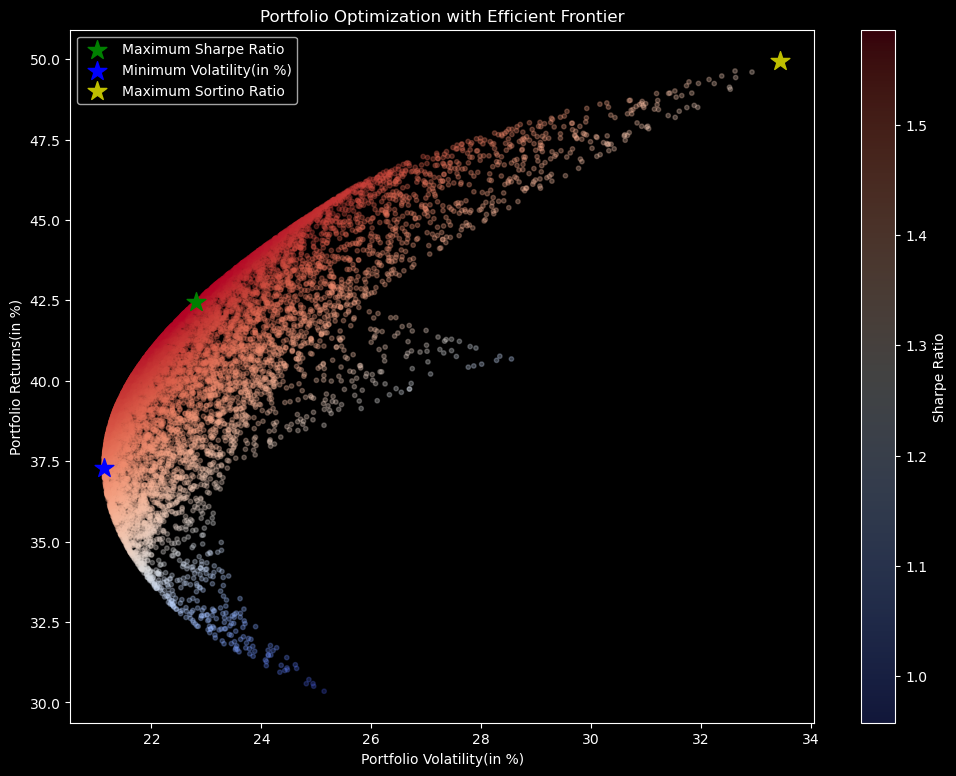

In [43]:
visualize_portfolio(portfolio_simulations,tangent_portfolio,min_variance_portfolio,max_sortino_portfolio)


🔎 Value at Risk (VaR) and Conditional VaR (CVaR):
Historical VaR: -0.0233
Historical CVaR: -0.0319
Parametric VaR: -0.0220
Monte Carlo VaR: -0.0218
Monte Carlo CVaR: -0.0277


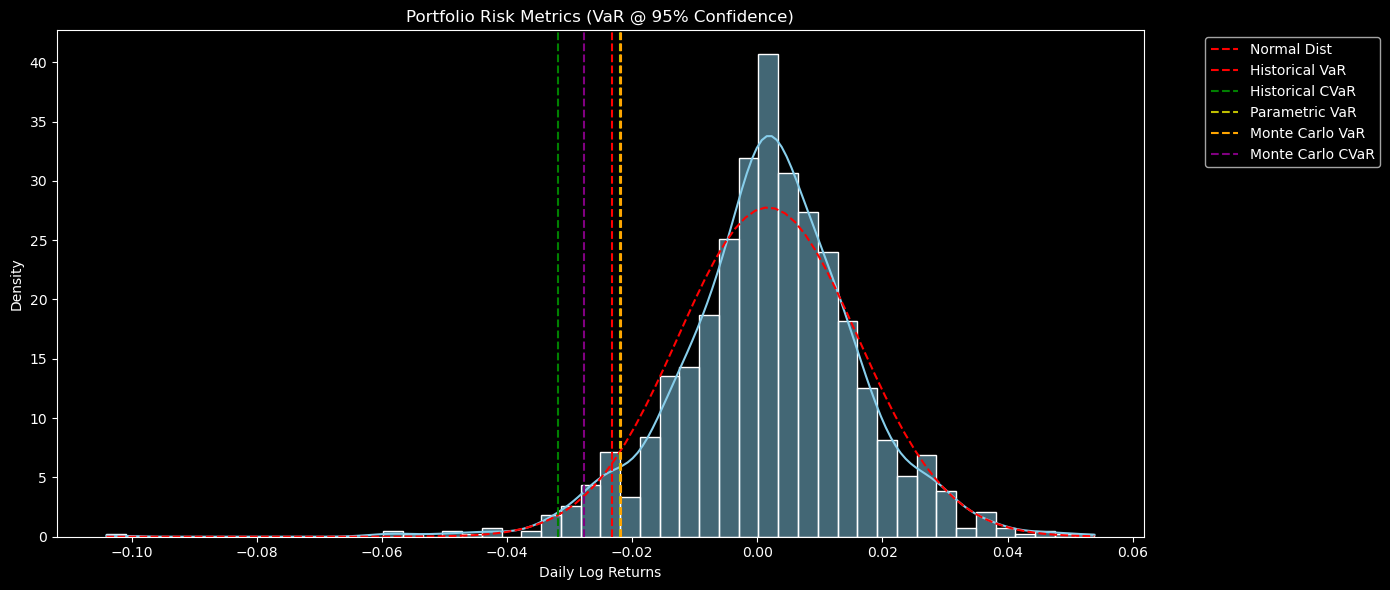

In [44]:
value_at_risk(daily_logret,tangent_portfolio)

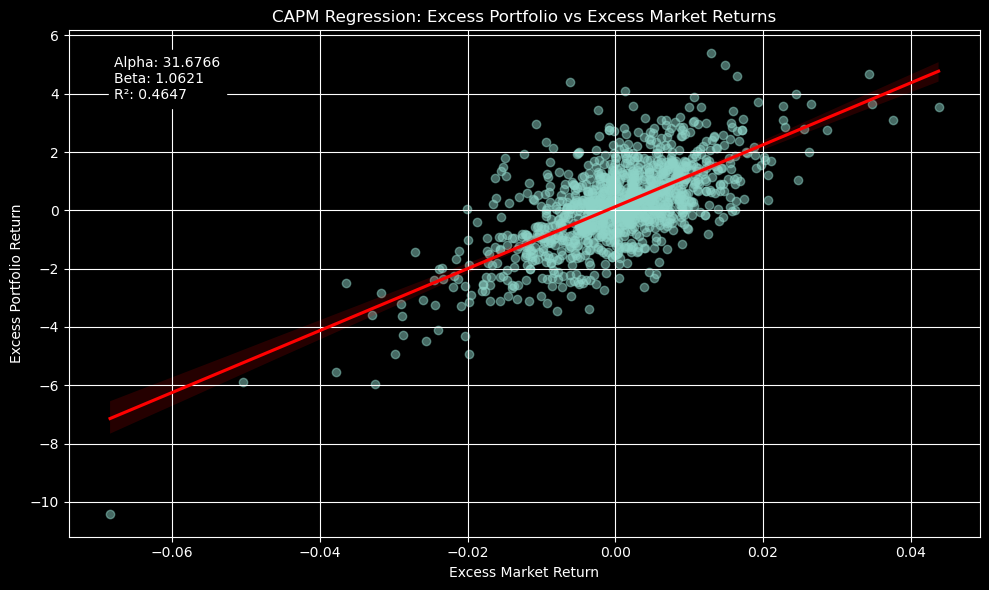

{'alpha (annualized)': 31.67665, 'beta': 1.06207, 'treynor_ratio': 0.00345, 'r_squared': 0.4647}


In [58]:
capm = alpha_beta(daily_logret, benchmark_logret, tangent_portfolio, start, end)
print(capm)

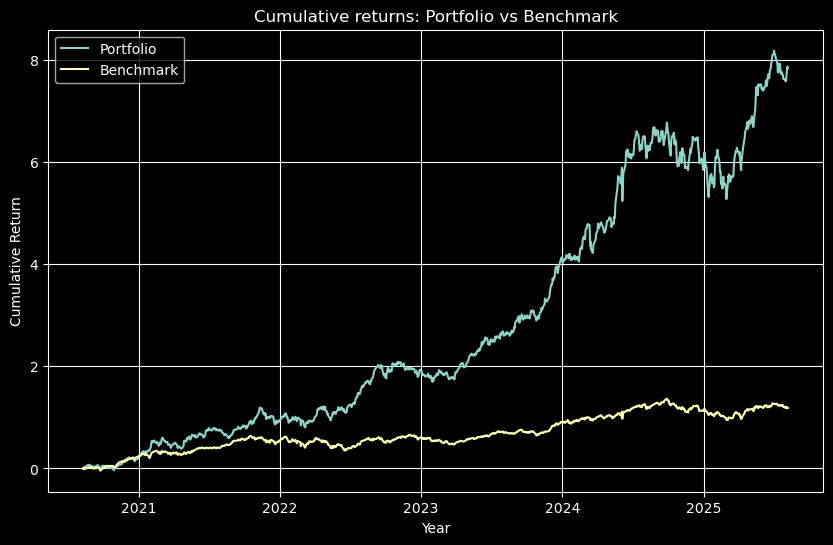

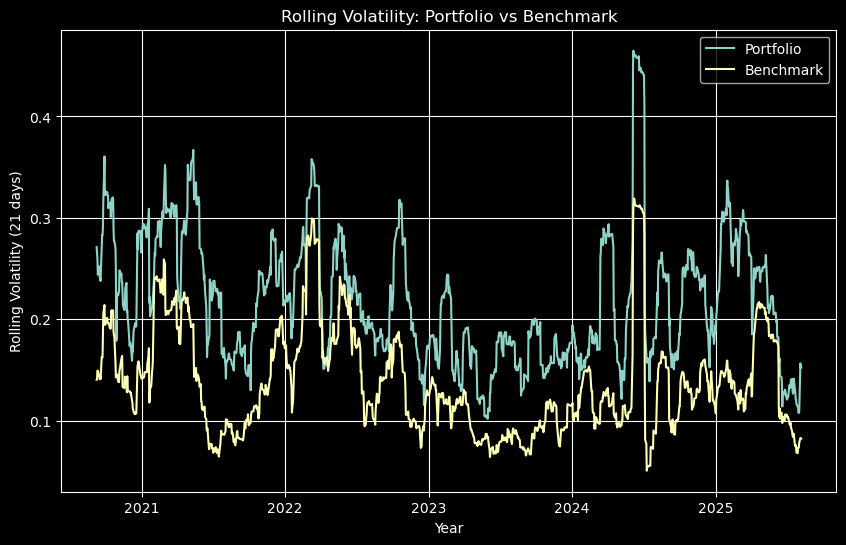

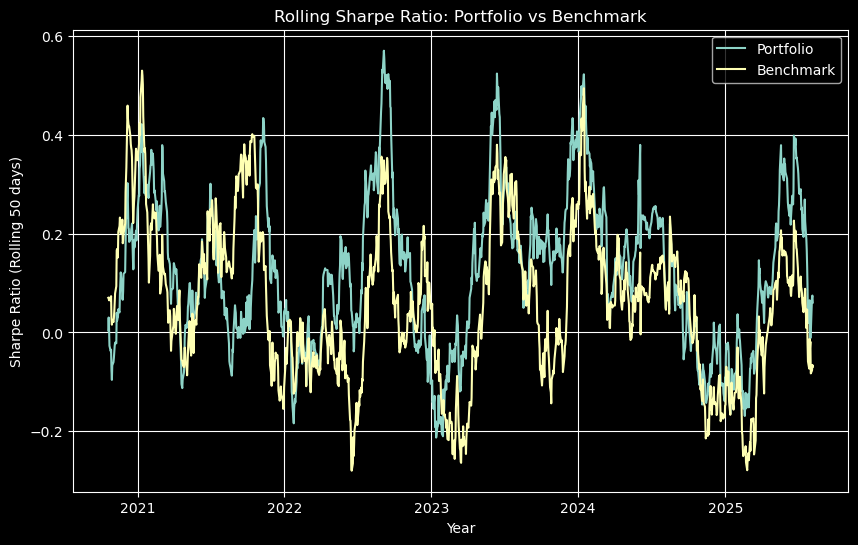

📉 Maximum Drawdown of the Portfolio: -0.19271379287228713
📉 Maximum Drawdown of the Benchmark: -0.1755600510277616


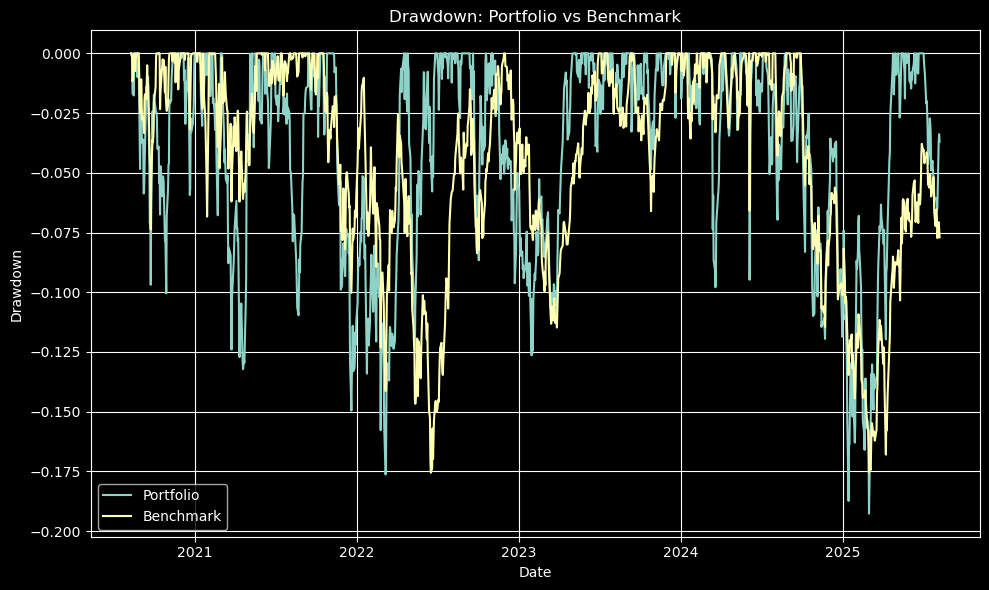

Sortino Ratio (Annualized): 2.52


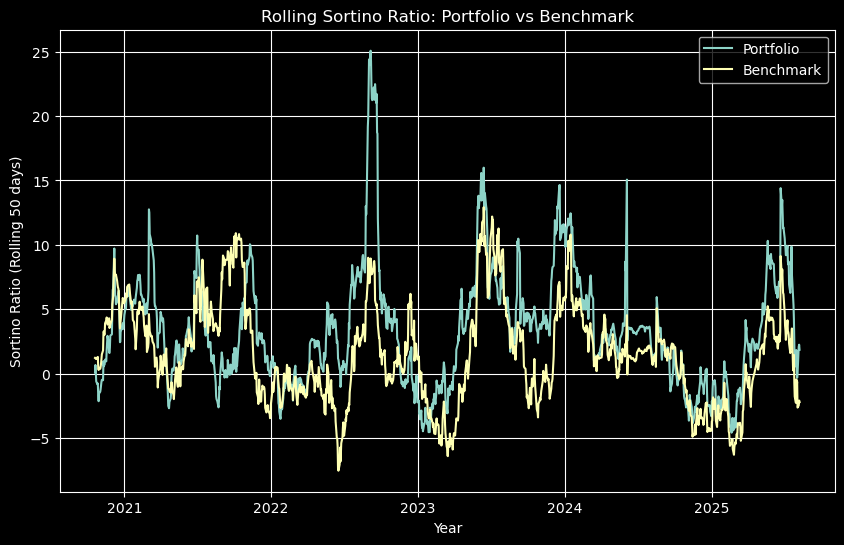

In [59]:
backtesting(daily_pctret, benchmark_pctret, tangent_portfolio['weights'], start, end)

⚠️ Weights don't sum to 1. Normalizing.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



📊 Random Forest Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.40      0.73      0.52       114
           1       0.70      0.38      0.49       196

    accuracy                           0.51       310
   macro avg       0.55      0.55      0.51       310
weighted avg       0.59      0.51      0.50       310



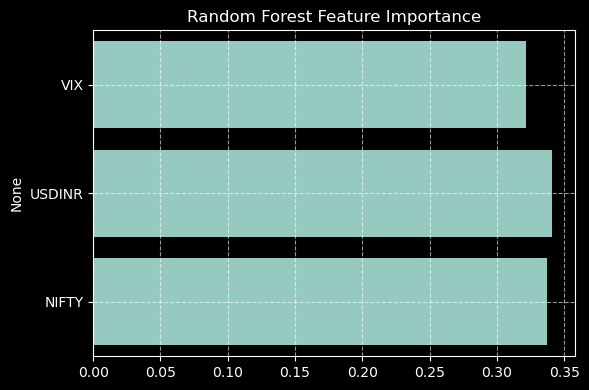

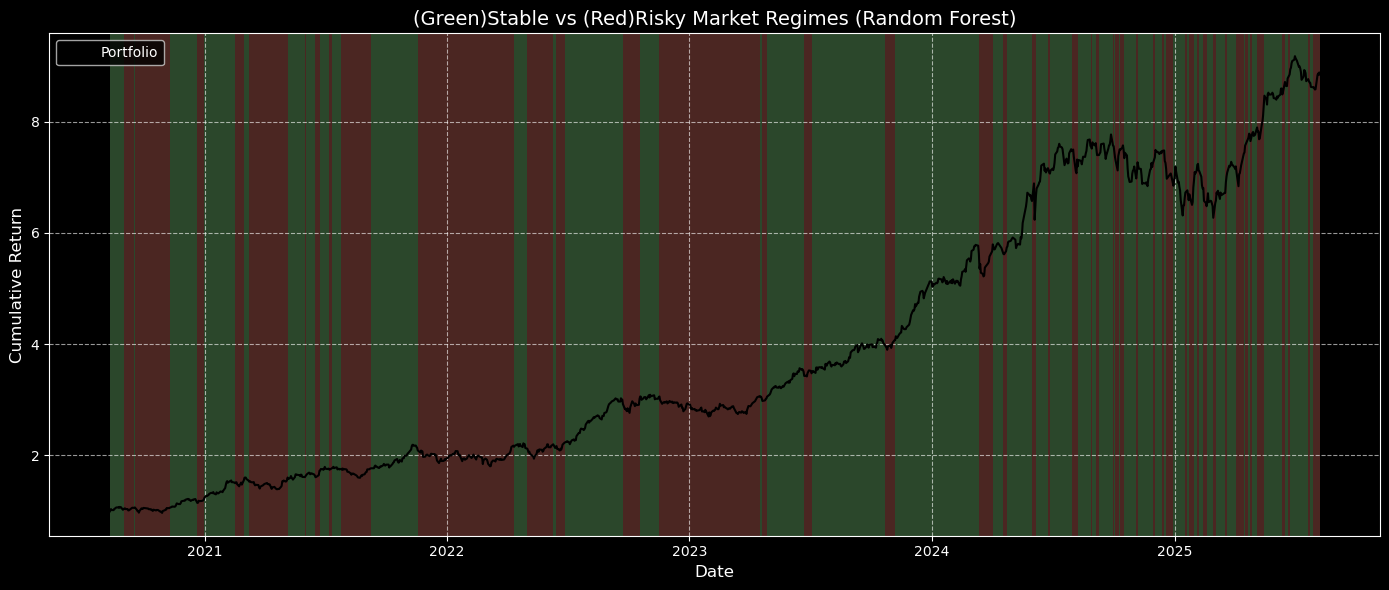

,Portfolio,VIX,USDINR,NIFTY,Label,Predicted_Regime,Smoothed_Regime
Date,,,,,,,
2020-08-11,-0.013693,-0.051088,0.001002,0.004645,0,0,0
2020-08-12,0.019314,-0.023876,-0.002663,-0.001245,0,0,0
2020-08-13,0.027571,-0.013429,-0.001708,-0.000703,0,0,0
2020-08-14,-0.016795,0.053476,0.003449,-0.010800,0,0,0
2020-08-17,-0.000855,-0.016613,-0.001695,0.006146,0,0,0
...,...,...,...,...,...,...,...
2025-08-01,0.000396,0.038128,-0.002567,-0.008196,1,1,1
2025-08-04,0.029730,-0.000835,-0.002790,0.006407,1,0,1
2025-08-05,0.003354,-0.021721,0.007427,-0.002961,1,1,1


In [60]:
combined = detect_market_regime_rf(start, end, daily_pctret, tangent_portfolio['weights'], threshold=-0.02)
combined